# Pensacola Bay FL - Detailed step-by-step

## Standardize, clean and wrangle Water Quality Portal data in Pensacola and Perdido Bays into more analytic-ready formats using the harmonize_wq package


US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:

- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Pensacola and Perdido Bays

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
#!python -m pip install harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

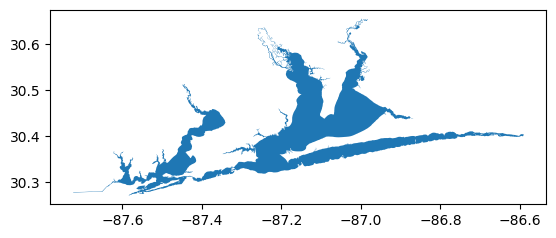

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://raw.githubusercontent.com/USEPA/harmonize-wq/main/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)  # already standard 4326
aoi_gdf.plot()

In [4]:
# Note there are actually two polygons (one for each Bay)
aoi_gdf
# Spatial query parameters can be updated to run just one
bBox = wrangle.get_bounding_box(aoi_gdf)
# For only one bay, e.g., first is Pensacola Bay:
#bBox = wrangle.get_bounding_box(aoi_gdf, 0)

In [5]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [6]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [7]:
# Rows and columns for results
stations.shape

(2583, 37)

In [8]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-AL,USGS Alabama Water Science Center,USGS-02376115,"ELEVENMILE CREEK NR WEST PENSACOLA, FL",Stream,NaN,3140107.0,27.8,sq mi,27.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-AL,USGS Alabama Water Science Center,USGS-02377570,"STYX RIVER NEAR ELSANOR, AL.",Stream,NaN,3140106.0,192.0,sq mi,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-AL,USGS Alabama Water Science Center,USGS-02377920,"BLACKWATER RIVER AT US HWY 90 NR ROBERTSDALE, AL.",Stream,NaN,3140106.0,23.1,sq mi,23.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-AL,USGS Alabama Water Science Center,USGS-02377960,"BLACKWATER RIVER AT CO RD 87 NEAR ELSANOR, AL.",Stream,NaN,3140106.0,56.6,sq mi,56.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-AL,USGS Alabama Water Science Center,USGS-02377975,BLACKWATER RIVER ABOVE SEMINOLE AL,Stream,NaN,3140106.0,40.2,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [9]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 30.498252
LongitudeMeasure                               -87.335809
Name: 0, dtype: object

In [10]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, out_EPSG=4326, intermediate_columns=True)

In [11]:
location.harmonize_locations?

Signature:
location.harmonize_locations(
    df_in,
    out_EPSG=4326,
    intermediate_columns=False,
    **kwargs,
)
Docstring:
Takes a DataFrame with lat/lon in multiple Coordinate Reference Systems,
transforms them to outCRS and converts to GeoDataFrame

Parameters
----------
df_in : pandas.DataFrame
    DataFrame with the required columns to be converted to GeoDataFrame.
out_EPSG : Integer, optional
    EPSG factory code for desired output Coordinate Reference System datum.
    The default is 4326, for the WGS84 Datum used by WQP queries.
intermediate_columns : Boolean, optional
    Return intermediate columns. Default 'False' does not return these.
Keyword Arguments:
crs_col : string, optional
    Name of column in DataFrame with the Coordinate Reference System datum.
    The default is 'HorizontalCoordinateReferenceSystemDatumName'.
lat_col : string, optional
    Name of column in DataFrame with the latitude coordinate.
    The default is 'LatitudeMeasure'.
lon_col : string, opt

In [12]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(2583, 42)

In [13]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-87.3358086, 30.49825159)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-87.3358086 30.49825159)
geometry     POINT (-87.3358086 30.49825159)
Name: 0, dtype: object

In [14]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [15]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'}

<Axes: >

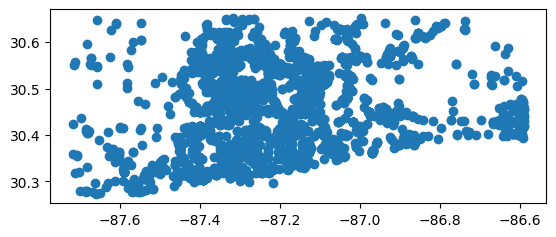

In [16]:
# Map it
stations_gdf.plot()

In [17]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

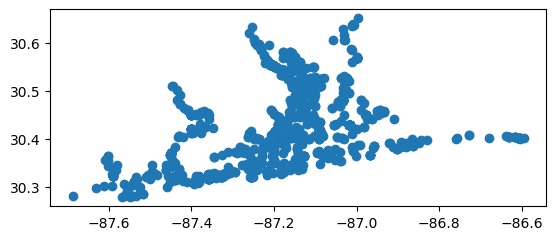

In [18]:
# Map it
stations_clipped.plot()

In [19]:
# How many stations now?
len(stations_clipped)

1241

In [20]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'PPBEP_stations.shp'))

#### Retrieve Characteristic Data

In [21]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (9,10,13,15,17,19,20,21,22,23,28,31,33,34,36,58,60,61,64,65,69,70,71,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [22]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-027950424132,2013-04-24,09:01:00,EST,21FLSEAS_WQX-02SEAS795,STORET-310551339,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-027400613134,2013-06-13,10:01:00,EST,21FLSEAS_WQX-02SEAS740,STORET-310489836,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,2013-09-17,11:01:00,EST,21FLPNS_WQX-33030019,STORET-308146602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520810L,2013-07-23,10:01:00,EST,21FLPNS_WQX-33020146,STORET-308157908,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,2013-09-23,17:15:00,CST,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380143,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,CST,USGS-02376108,NWIS-6891917,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
380144,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900926,1959-02-05,NaN,NaN,USGS-303820086241802,NWIS-6917199,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
380145,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900852,1959-02-02,NaN,NaN,USGS-302330086482001,NWIS-6916923,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
380146,USGS-AL,USGS Alabama Water Science Center,nwisal.01.02200090,2022-09-14,13:15:00,CDT,USGS-302438087325801,NWIS-124465070,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

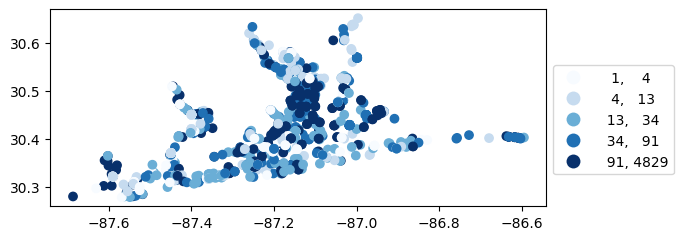

In [23]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [24]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize_generic?

##### secchi disk depth

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    12259.000000
mean         1.162508
std          2.482428
min          0.000000
25%          0.600000
50%          1.000000
75%          1.494808
max        260.000000
dtype: float64
Unusable results: 35
Usable results with inferred units: 0
Results outside threshold (0.0 to 16.057074551495145): 1


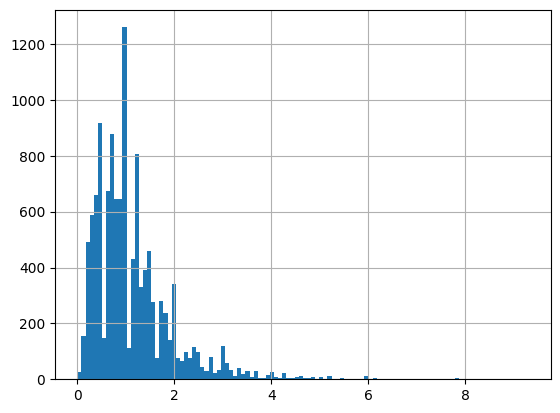

In [25]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [26]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
76,21AWIC-7290,.94,m,NaN,m,0.94 meter
88,21FLPNS_WQX-33020JF1,0.60,m,NaN,m,0.6 meter
105,21FLGW_WQX-3565,.3,m,NaN,m,0.3 meter
115,21FLBFA_WQX-33010016,1.5,m,NaN,m,1.5 meter
118,21FLBFA_WQX-33010030,1.25,m,NaN,m,1.25 meter
...,...,...,...,...,...,...
378738,21FLPNS_WQX-3302J2GS8,1,m,NaN,m,1.0 meter
378741,21FLPNS_WQX-G4NW0521,1,m,NaN,m,1.0 meter
378748,21FLPNS_WQX-G5NW0035,0.9,m,NaN,m,0.9 meter
378761,21FLPNS_WQX-3302J7GS12,4,m,NaN,m,4.0 meter


In [27]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
141278,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
142645,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
143134,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
145265,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
164839,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
167561,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
168257,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
172701,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
173355,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
175027,21FLKWAT_WQX-OKA-CB-SANROS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [28]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [29]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
141278,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
142645,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
143134,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
145265,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
164839,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
167561,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
168257,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
172701,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
173355,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
175027,21FLKWAT_WQX-OKA-CB-SANROS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [30]:
# Aggregate Secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_CMP_PKT01,12,2.333333
1,11NPSWRD_WQX-GUIS_CMP_PKT02,17,2.411765
2,11NPSWRD_WQX-GUIS_CMP_PKT03,3,2.333333
3,21AWIC-1063,116,0.767931
4,21AWIC-1122,56,2.790786
...,...,...,...
868,NARS_WQX-NCCA10-1432,1,1.075000
869,NARS_WQX-NCCA10-1433,1,1.423333
870,NARS_WQX-NCCA10-1434,1,2.400000
871,NARS_WQX-NCCA10-1488,1,0.736667


<Axes: >

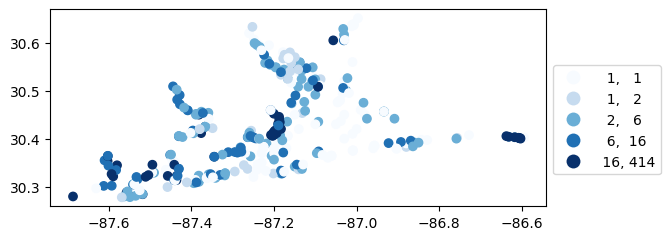

In [31]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

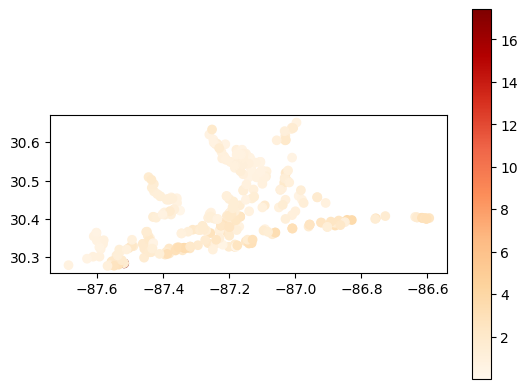

In [32]:
# Map average secchi depth results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    73953.000000
mean        21.877672
std         10.712241
min        -12.944444
25%         16.900000
50%         22.170000
75%         27.100000
max       1876.000000
dtype: float64
Unusable results: 2
Usable results with inferred units: 10
Results outside threshold (0.0 to 86.1511173604885): 7


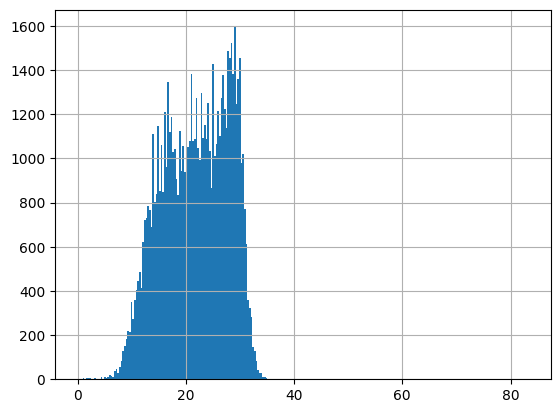

In [33]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [34]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
4,21FLCBA_WQX-BAS02,78.9,deg F,NaN,26.0555555555556 degree_Celsius,degF
6,21FLPNS_WQX-33020J10,12.35,deg C,NaN,12.35 degree_Celsius,degC
21,21FLSEAS_WQX-02SEAS810,23,deg C,NaN,23.0 degree_Celsius,degC
22,21FLPNS_WQX-33010G10,11.23,deg C,NaN,11.23 degree_Celsius,degC
37,21FLPNS_WQX-33030019,23.12,deg C,NaN,23.12 degree_Celsius,degC
...,...,...,...,...,...,...
380133,USGS-302703087133501,24.0,deg C,NaN,24.0 degree_Celsius,degC
380136,USGS-303733086441001,22.2,deg C,NaN,22.2 degree_Celsius,degC
380139,USGS-302703087133502,24.0,deg C,NaN,24.0 degree_Celsius,degC
380142,USGS-02376108,24.4,deg C,NaN,24.4 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
148874,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
197948,21FLCBA-FWB05,79.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.8 degree_Celsius,degC
198014,21FLCBA-FWB05,81.7,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",81.7 degree_Celsius,degC
198895,21FLCBA-FWB02,82.1,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.1 degree_Celsius,degC
198896,21FLCBA-FWB02,82.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.6 degree_Celsius,degC
198897,21FLCBA-FWB02,71.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.8 degree_Celsius,degC
198898,21FLCBA-FWB02,79.4,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.4 degree_Celsius,degC
204579,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
204580,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
209210,21FLCBA-FWB01,83.3,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",83.3 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
49318,11NPSWRD_WQX-GUIS_NALO,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
148874,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,24.986667
1,11NPSWRD_WQX-GUIS_BCCA,1,36.800000
2,11NPSWRD_WQX-GUIS_BISA,32,22.696250
3,11NPSWRD_WQX-GUIS_BOPI,1,32.000000
4,11NPSWRD_WQX-GUIS_CMP_PKT01,20,25.125000
...,...,...,...
2184,USGS-304240087333701,1,26.000000
2185,USGS-304506087370501,1,22.000000
2186,USGS-304508087370701,1,22.000000
2187,USGS-304600087320001,1,23.000000


<Axes: >

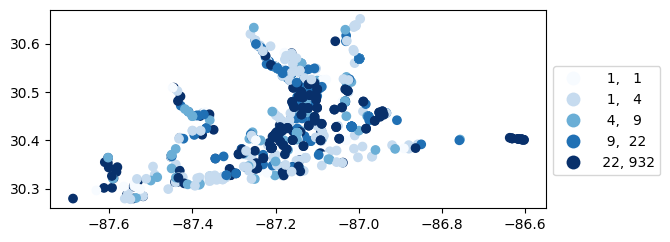

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

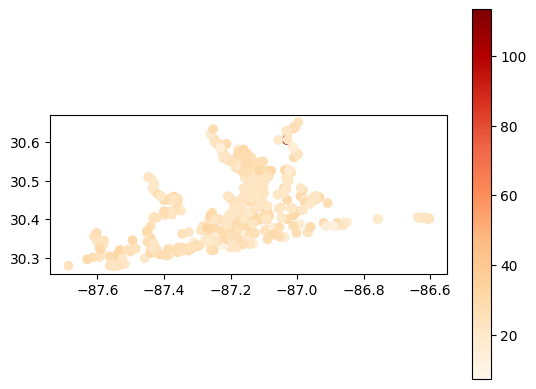

In [40]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
1,21FLSEAS_WQX-02SEAS740,6.3,mg/L,NaN,6.3 milligram / liter
5,21FLCMP_WQX-3201BM21,4.5,mg/L,NaN,4.5 milligram / liter
12,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
17,21FLBFA_WQX-33020057,1.17,mg/L,NaN,1.17 milligram / liter
35,21FLCBA_WQX-SRS03,6.28,mg/L,NaN,6.28 milligram / liter
...,...,...,...,...,...
380080,21AWIC-1152,8.5,mg/L,NaN,8.5 milligram / liter
380082,21AWIC-1152,8.48,mg/L,NaN,8.48 milligram / liter
380088,21AWIC-1152,7.35,mg/L,NaN,7.35 milligram / liter
380093,21AWIC-1152,9.1,mg/L,NaN,9.1 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
1,21FLSEAS_WQX-02SEAS740,6.3,mg/L,NaN,6.3 milligram / liter
5,21FLCMP_WQX-3201BM21,4.5,mg/L,NaN,4.5 milligram / liter
12,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
17,21FLBFA_WQX-33020057,1.17,mg/L,NaN,1.17 milligram / liter
35,21FLCBA_WQX-SRS03,6.28,mg/L,NaN,6.28 milligram / liter
...,...,...,...,...,...
380080,21AWIC-1152,8.5,mg/L,NaN,8.5 milligram / liter
380082,21AWIC-1152,8.48,mg/L,NaN,8.48 milligram / liter
380088,21AWIC-1152,7.35,mg/L,NaN,7.35 milligram / liter
380093,21AWIC-1152,9.1,mg/L,NaN,9.1 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate DO data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,6.698000
1,11NPSWRD_WQX-GUIS_BCCA,1,0.270000
2,11NPSWRD_WQX-GUIS_BISA,32,7.194375
3,11NPSWRD_WQX-GUIS_BOPI,1,7.540000
4,11NPSWRD_WQX-GUIS_FPPO,1,9.950000
...,...,...,...
1797,NARS_WQX-NCCA10-1433,16,6.931250
1798,NARS_WQX-NCCA10-1434,26,6.280769
1799,NARS_WQX-NCCA10-1488,8,5.903750
1800,NARS_WQX-NCCA10-2432,12,6.650000


<Axes: >

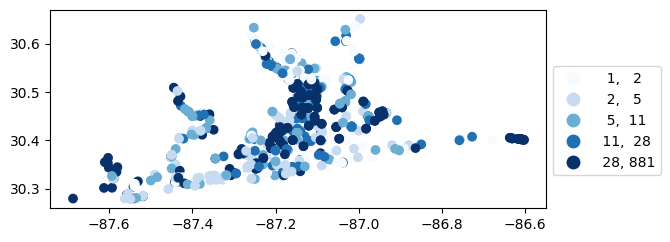

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

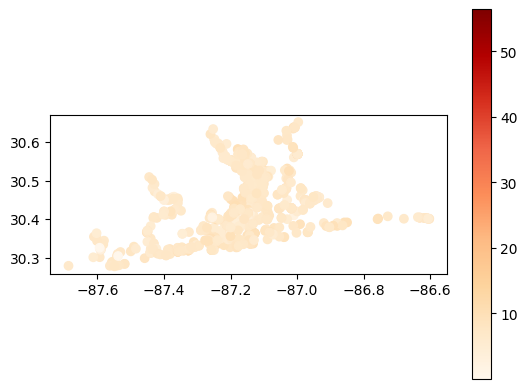

In [46]:
# Map Averages at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### pH

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    52743.000000
mean         7.357375
std          0.901695
min          0.500000
25%          6.900000
50%          7.700000
75%          8.000000
max         16.200000
dtype: float64
Unusable results: 51
Usable results with inferred units: 36
Results outside threshold (0.0 to 12.7675480597104): 1


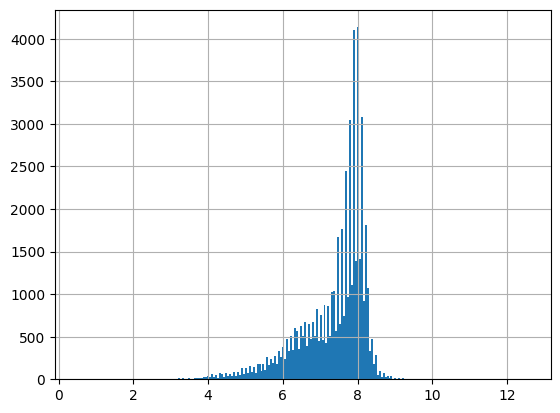

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
2,7.29,None,NaN,7.29 dimensionless
20,8.09,None,NaN,8.09 dimensionless
24,7.45,None,NaN,7.45 dimensionless
26,6.57,None,NaN,6.57 dimensionless
28,6.57,None,NaN,6.57 dimensionless
...,...,...,...,...
380141,7.9,std units,NaN,7.9 dimensionless
380143,8.3,std units,NaN,8.3 dimensionless
380144,6.6,std units,NaN,6.6 dimensionless
380145,8.1,std units,NaN,8.1 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    67151.000000
mean        16.310648
std        157.608152
min          0.000000
25%          6.700000
50%         16.480000
75%         23.600000
max      37782.000000
dtype: float64
Unusable results: 416
Usable results with inferred units: 10
Results outside threshold (0.0 to 961.9595587855733): 4


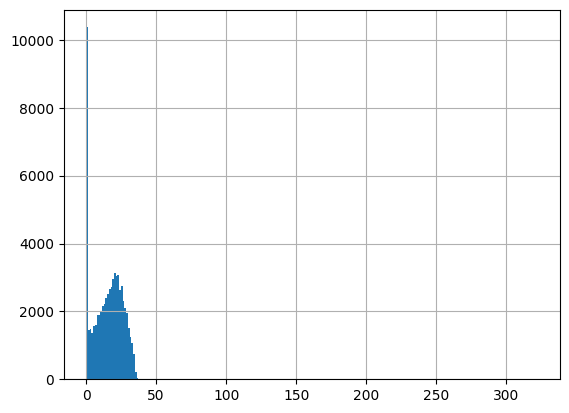

In [49]:
# Salinity
df = harmonize.harmonize_generic(df, 'Salinity', report=True)

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
9,18.9,ppth,NaN,18.9 Practical_Salinity_Units
11,11.82,ppth,NaN,11.82 Practical_Salinity_Units
18,.03,ppt,NaN,0.03 Practical_Salinity_Units
23,33.27,ppth,NaN,33.27 Practical_Salinity_Units
27,25.16,ppth,NaN,25.16 Practical_Salinity_Units
...,...,...,...,...
380072,.01,ppt,NaN,0.01 Practical_Salinity_Units
380074,.01,ppt,NaN,0.01 Practical_Salinity_Units
380084,.01,ppt,NaN,0.01 Practical_Salinity_Units
380094,.01,ppt,NaN,0.01 Practical_Salinity_Units


###### Nitrogen

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     109.000000
mean       26.920174
std       160.257726
min         0.000700
25%         0.410000
50%         0.629000
75%         1.120000
max      1630.000000
dtype: float64
Unusable results: 4
Usable results with inferred units: 0
Results outside threshold (0.0 to 988.4665321860789): 1


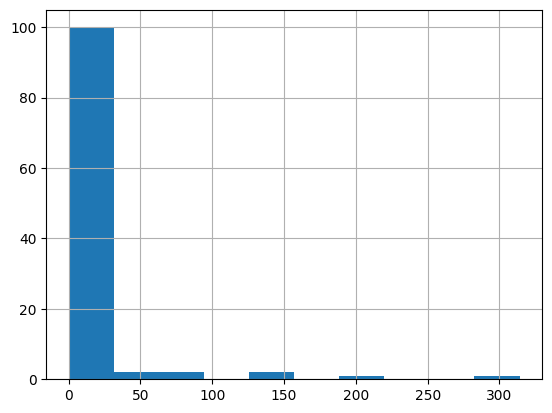

In [51]:
# Nitrogen
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
40849,0.3,mg/L,NaN,0.3 milligram / liter
41092,0.36,mg/L,NaN,0.36 milligram / liter
41177,0.33875,mg/L,NaN,0.33875 milligram / liter
41263,0.53125,mg/L,NaN,0.53125 milligram / liter
41817,135,mg/kg,NaN,135.00000000000003 milligram / liter
...,...,...,...,...
379457,17.61,mg/l,NaN,17.61 milligram / liter
379484,0.0007,cm3/g STP,ResultMeasure/MeasureUnitCode: 'cm3/g' UNDEFIN...,0.0007 milligram / liter
379486,0.0146,cm3/g @STP,ResultMeasure/MeasureUnitCode: 'cm3/g' UNDEFIN...,0.0146 milligram / liter
379492,0.0008,cm3/g STP,ResultMeasure/MeasureUnitCode: 'cm3/g' UNDEFIN...,0.0008 milligram / liter


###### Conductivity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     1818.000000
mean     17085.221414
std      16116.889030
min          0.040000
25%        130.000000
50%      16994.750000
75%      30306.650000
max      54886.200000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 113786.55559242623): 0


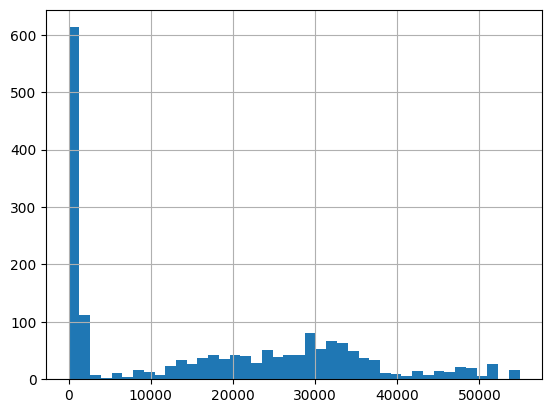

In [53]:
# Conductivity
df = harmonize.harmonize_generic(df, 'Conductivity', report=True)

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
14,19204.2,umho/cm,NaN,19204.2 microsiemens / centimeter
85,222.3,umho/cm,NaN,222.3 microsiemens / centimeter
179,102.8,umho/cm,NaN,102.8 microsiemens / centimeter
359,11017.5,umho/cm,NaN,11017.5 microsiemens / centimeter
731,32,umho/cm,NaN,32.0 microsiemens / centimeter
...,...,...,...,...
379899,110,umho/cm,NaN,110.0 microsiemens / centimeter
379904,65,umho/cm,NaN,65.0 microsiemens / centimeter
379906,110,umho/cm,NaN,110.0 microsiemens / centimeter
379909,390,umho/cm,NaN,390.0 microsiemens / centimeter


###### Chlorophyll a

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'None' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:131: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    9144.000000
mean        1.185185
std         1.200473
min        -0.840000
25%         0.009051
50%         0.990000
75%         1.860000
max         9.990000
dtype: float64
Unusable results: 548
Usable results with inferred units: 0
Results outside threshold (0.0 to 8.388024348354165): 8


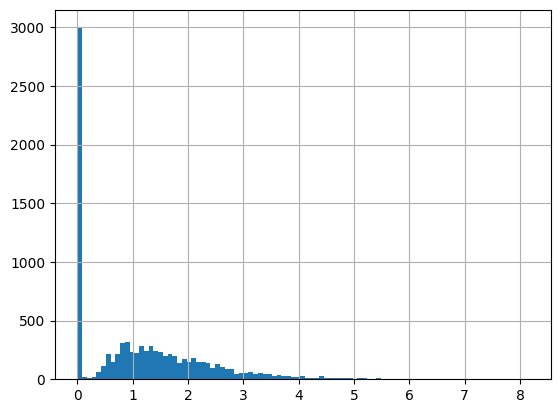

In [55]:
# Chlorophyll a
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
231,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
521,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
614,2.3,mg/m3,NaN,0.0023000000000000004 milligram / liter
1115,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
1253,2.9,mg/m3,NaN,0.0029000000000000007 milligram / liter
...,...,...,...,...
379977,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
379997,1.3,mg/m3,NaN,0.0013000000000000004 milligram / liter
380070,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
380081,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Organic Carbon

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      4303.000000
mean       1276.060789
std       12267.124879
min           0.000000
25%           2.600000
50%           4.300000
75%           8.600000
max      410000.000000
dtype: float64
Unusable results: 161
Usable results with inferred units: 0
Results outside threshold (0.0 to 74878.8100613949): 22


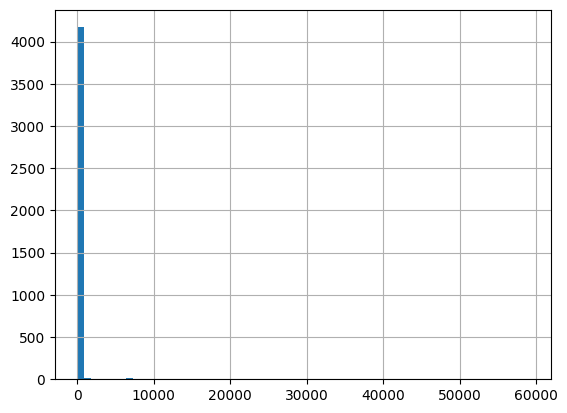

In [57]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
114,2.6,mg/L,NaN,2.6 milligram / liter
147,3.9,mg/L,NaN,3.9 milligram / liter
195,5.2,mg/L,NaN,5.2 milligram / liter
208,NaN,mg/L,ResultMeasureValue: missing (NaN) result,NaN
214,2.5,mg/L,NaN,2.5 milligram / liter
...,...,...,...,...
379983,8.291,mg/L,NaN,8.291 milligram / liter
379993,8.026,mg/L,NaN,8.026 milligram / liter
380065,4.159,mg/L,NaN,4.159 milligram / liter
380079,3.059,mg/L,NaN,3.059 milligram / liter


###### Turbidity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    37569.000000
mean         9.062143
std        211.754723
min         -0.100000
25%          1.450000
50%          2.500000
75%          4.860000
max      32342.452300
dtype: float64
Unusable results: 167
Usable results with inferred units: 10
Results outside threshold (0.0 to 1279.59047931992): 27


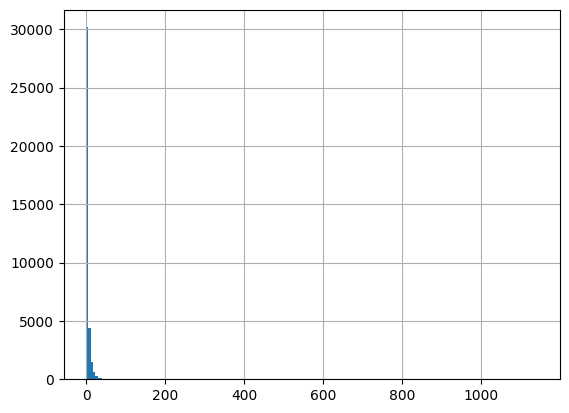

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize_generic(df, 'Turbidity', report=True)

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
13,2,NTU,NaN,2.0 Nephelometric_Turbidity_Units
25,0,NTU,NaN,0.0 Nephelometric_Turbidity_Units
43,1.4,NTU,NaN,1.4 Nephelometric_Turbidity_Units
48,4.7,NTU,NaN,4.7 Nephelometric_Turbidity_Units
94,5.6,NTU,NaN,5.6 Nephelometric_Turbidity_Units
...,...,...,...,...
380037,50,JTU,NaN,951.2022999999999 Nephelometric_Turbidity_Units
380045,1700,JTU,NaN,32342.452299999997 Nephelometric_Turbidity_Units
380071,16.2,NTU,NaN,16.2 Nephelometric_Turbidity_Units
380077,3.2,NTU,NaN,3.2 Nephelometric_Turbidity_Units


###### Sediment

In [61]:
# Sediment
df = harmonize.harmonize_generic(df, 'Sediment', report=False)

In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
379633,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
379649,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize_generic(df, 'Phosphorus')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
34,.061,mg/L,NaN,NaN
143,.13,mg/L,NaN,NaN
167,0.003,mg/L,NaN,NaN
296,0.002,mg/L,NaN,NaN
384,0.020,mg/L,NaN,NaN
...,...,...,...,...
379969,.044,mg/L,NaN,NaN
379981,.029,mg/L,NaN,NaN
379982,.045,mg/L,NaN,NaN
380066,.032,mg/L,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
34,.061,mg/L,NaN,NaN
143,.13,mg/L,NaN,NaN
167,0.003,mg/L,NaN,NaN
296,0.002,mg/L,NaN,NaN
384,0.020,mg/L,NaN,NaN
...,...,...,...,...
379969,.044,mg/L,NaN,NaN
379981,.029,mg/L,NaN,NaN
379982,.045,mg/L,NaN,NaN
380066,.032,mg/L,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3436,0.019,mg/L,NaN,0.019 milligram / liter
7564,0.002,mg/L,NaN,0.002 milligram / liter
30670,0.003,mg/L,NaN,0.003 milligram / liter
33630,0.019,mg/L,NaN,0.019 milligram / liter
53255,0.002,mg/L,NaN,0.002 milligram / liter
54549,0.017,mg/L,NaN,0.017 milligram / liter
69615,0.021,mg/L,NaN,0.021 milligram / liter
72228,0.003,mg/L,NaN,0.003 milligram / liter
96225,0.020,mg/L,NaN,0.02 milligram / liter
101331,0.002,mg/L,NaN,0.002 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
9628,.5,mg/L,NaN,NaN
9699,.036,mg/L,NaN,NaN
10941,.089,mg/L,NaN,NaN
11843,.017,mg/L,NaN,NaN
12906,.035,mg/L,NaN,NaN
...,...,...,...,...
379868,.18,mg/L,NaN,NaN
379877,.25,mg/L,NaN,NaN
379891,.16,mg/L,NaN,NaN
379894,.18,mg/L,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count    10035.000000
mean        45.537618
std        448.839329
min          0.000000
25%          4.000000
50%          8.000000
75%         33.000000
max      33000.000000
dtype: float64
Unusable results: 40526
Usable results with inferred units: 0
Results outside threshold (0.0 to 2738.5735941387825): 6


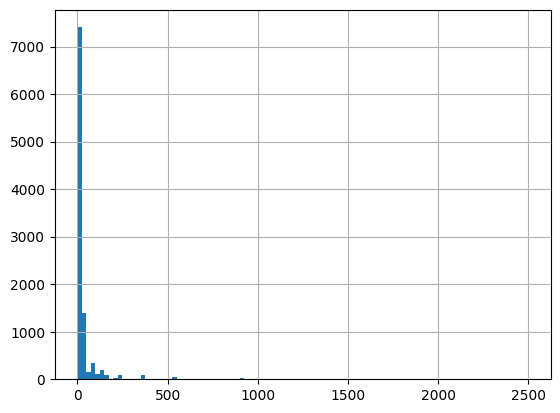

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
0,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
3,80,cfu/100mL,NaN,NaN
7,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
8,2,MPN/100mL,NaN,NaN
10,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
...,...,...,...,...
379663,145,cfu/100mL,NaN,NaN
379689,317,cfu/100mL,NaN,NaN
379711,60,cfu/100mL,NaN,NaN
379781,600,cfu/100mL,NaN,NaN


###### Escherichia coli

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:645: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn("WARNING: '{}' converted to NaN".format(unit))


-Usable results-
count      22.000000
mean      501.863636
std       610.053260
min         4.000000
25%         9.500000
50%        77.500000
75%      1000.000000
max      1700.000000
dtype: float64
Unusable results: 2702
Usable results with inferred units: 0
Results outside threshold (0.0 to 4162.183198738116): 0


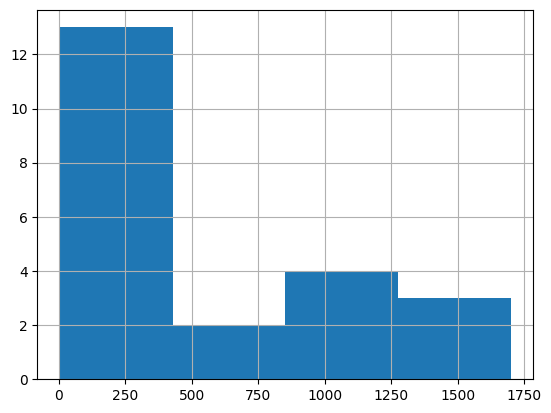

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
316,190,MPN/100mL,NaN,NaN
1139,36,MPN/100mL,NaN,NaN
1792,63,MPN/100mL,NaN,NaN
2046,44,#/100mL,NaN,NaN
2418,270,#/100mL,NaN,NaN
...,...,...,...,...
379965,460,MPN/100mL,NaN,NaN
379976,15,MPN/100mL,NaN,NaN
380063,1500,MPN/100mL,NaN,NaN
380076,110,MPN/100mL,NaN,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 37782.0
Results: 67151 
Mean: 16.310647585293 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[15030.0, 37782.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
29285,15030,ppt,NaN,15030.0 Practical_Salinity_Units
38421,322,ppth,NaN,322.0 Practical_Salinity_Units
40396,2150,ppth,NaN,2150.0 Practical_Salinity_Units
65862,37782,ppth,NaN,37782.0 Practical_Salinity_Units
136203,2190,ppt,NaN,2190.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
from harmonize_wq import wrangle

In [78]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [79]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
2027,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
3544,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
16678,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
17285,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
19667,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
377770,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
377776,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
377779,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
377786,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [80]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

14        19204.2 microsiemens / centimeter
85          222.3 microsiemens / centimeter
179         102.8 microsiemens / centimeter
359       11017.5 microsiemens / centimeter
731          32.0 microsiemens / centimeter
                        ...                
379899      110.0 microsiemens / centimeter
379904       65.0 microsiemens / centimeter
379906      110.0 microsiemens / centimeter
379909      390.0 microsiemens / centimeter
379912       65.0 microsiemens / centimeter
Name: Conductivity, Length: 1818, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [81]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
123225,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
126334,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
120037,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
125145,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
119452,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
81740,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
136314,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
48926,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
20653,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [82]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
123225,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
126334,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
120037,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
125145,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
119452,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
81740,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
136314,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
48926,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
20653,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [83]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

123225    36.356 dimensionless
126334    36.345 dimensionless
120037    36.338 dimensionless
125145    36.336 dimensionless
119452     36.33 dimensionless
                  ...         
81740      0.013 dimensionless
136314     0.012 dimensionless
48926      0.012 dimensionless
20653      0.012 dimensionless
137472     0.012 dimensionless
Name: Salinity, Length: 1818, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [84]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
123225,2007-08-09,12:15:00,CST
126334,2007-08-09,12:15:00,CST
120037,2007-08-09,12:15:00,CST
125145,2007-08-09,12:15:00,CST
119452,2007-08-09,12:15:00,CST
...,...,...,...
380143,1958-01-14,09:20:00,CST
380144,1959-02-05,NaN,NaN
380145,1959-02-02,NaN,NaN
380146,2022-09-14,13:15:00,CDT


In [85]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\utils.py:87: UserWarning: Warning: 35994 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
123225,2007-08-09,2007-08-09 18:15:00+00:00
126334,2007-08-09,2007-08-09 18:15:00+00:00
120037,2007-08-09,2007-08-09 18:15:00+00:00
125145,2007-08-09,2007-08-09 18:15:00+00:00
119452,2007-08-09,2007-08-09 18:15:00+00:00
...,...,...
380143,1958-01-14,1958-01-14 15:20:00+00:00
380144,1959-02-05,NaT
380145,1959-02-02,NaT
380146,2022-09-14,2022-09-14 18:15:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [86]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


2978       7.0
5560       7.0
69535      0.1
69611      2.2
69726      2.0
          ... 
78362      2.2
80021     16.0
81268     16.0
82376      1.0
131168    35.0
Name: ResultDepthHeightMeasure/MeasureValue, Length: 179, dtype: float64

#### Characteristic to Column (long to wide format)

In [87]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Conductivity,QA_Fecal_Coliform,QA_Turbidity,QA_Sediment,QA_DO,QA_pH,QA_Temperature
123225,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383613,230231.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126334,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383607,230230.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120037,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383595,230228.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125145,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383601,230229.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119452,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383589,230227.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380143,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,-0600,USGS-02376108,NWIS-6891917,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380144,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900926,1959-02-05,NaN,NaN,USGS-303820086241802,NWIS-6917199,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380145,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900852,1959-02-02,NaN,NaN,USGS-302330086482001,NWIS-6916923,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380146,USGS-AL,USGS Alabama Water Science Center,nwisal.01.02200090,2022-09-14,13:15:00,-0500,USGS-302438087325801,NWIS-124465070,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [89]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

44878 fewer rows


In [90]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [91]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [92]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'Conductivity', 'Chlorophyll', 'Carbon', 'Turbidity',
       'Sediment', 'Phosphorus', 'TP_Phosphorus', 'TDP_Phosphorus',
       'Other_Phosphorus', 'Fecal_Coliform', 'E_coli',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_E_coli', 'QA_Nitrogen', 'QA_Carbon',
       'QA_Salinity', 'QA_Secchi', 'QA_Chlorophyll', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Conductivity',
       'QA_Fecal_Coliform', 'QA_Turbidity', 'QA_Sediment', 'QA_DO', 'QA_pH',
       'QA_Temperature'],
      dtype='object')

In [93]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Conductivity,QA_Fecal_Coliform,QA_Turbidity,QA_Sediment,QA_DO,QA_pH,QA_Temperature
123225,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.356 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126334,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.345 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120037,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.338 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125145,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.336 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119452,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.33 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_E_coli',
 'QA_Carbon',
 'QA_Secchi',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Conductivity',
 'QA_Fecal_Coliform',
 'QA_Sediment']

<Axes: >

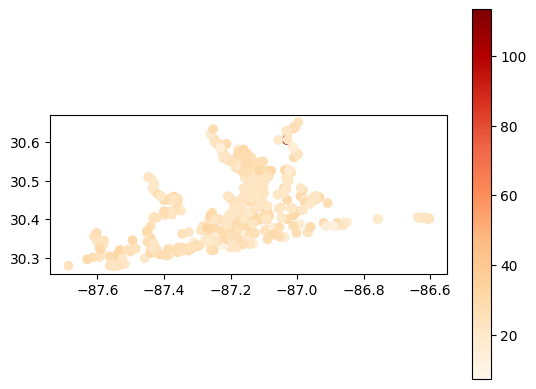

In [95]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)